In [1]:
### https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen

!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/test
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/train
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/train/augmentation
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/train/image
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/train/mask
!mkdir /home/youho/lung_segmentation_practice/practice_1/input/segmentation/train/dilate

In [2]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import multi_gpu_model

from glob import glob
from tqdm import tqdm

In [15]:
INPUT_DIR = os.path.join("/home/youho/lung_segmentation_practice/practice_1", "input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")

SEGMENTATION_SOURCE_DIR = os.path.join("/home/youho/data", "lung")

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "rightMask")

JSRT_TEST_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "JSRT")
JSRT_IMAGE_DIR = os.path.join(JSRT_TEST_DIR, "images")
JSRT_LEFT_MASK_DIR = os.path.join(JSRT_TEST_DIR, "masks", "left_lung_masks")
JSRT_RIGHT_MASK_DIR = os.path.join(JSRT_TEST_DIR, "masks", "right_lung_masks")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=20

#Prod
EPOCHS=120

#Desv
#EPOCHS=16

In [4]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))

for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), mask_dilate)


100%|██████████| 138/138 [00:47<00:00,  2.92it/s]


In [5]:
JSRT_left_mask_dir = glob(os.path.join(JSRT_LEFT_MASK_DIR, '*.png'))
JSRT_test = JSRT_left_mask_dir[0:100]
JSRT_train = JSRT_left_mask_dir[100:]

for left_image_file in tqdm(JSRT_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(JSRT_IMAGE_DIR, base_file)
    right_image_file = os.path.join(JSRT_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in JSRT_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), image)
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), mask_dilate)       
        
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), image)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)    

100%|██████████| 247/247 [00:17<00:00, 13.88it/s]


In [6]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), mask_dilate)

100%|██████████| 566/566 [01:17<00:00,  7.30it/s]


In [7]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

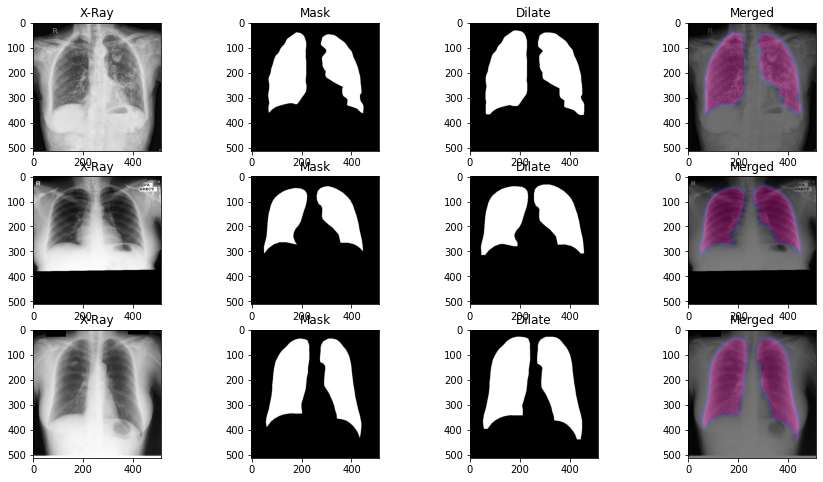

In [8]:
montgomery_train = montgomery_left_mask_dir
shenzhen_train = shenzhen_mask_dir

base_file = os.path.basename(shenzhen_train[1].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(3, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_train[1])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

base_file = os.path.basename(JSRT_test[1])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[2, 0].set_title("X-Ray")
axs[2, 0].imshow(image)

axs[2, 1].set_title("Mask")
axs[2, 1].imshow(mask_image)

axs[2, 2].set_title("Dilate")
axs[2, 2].imshow(dilate_image)

axs[2, 3].set_title("Merged")
axs[2, 3].imshow(merged_image)

100%|██████████| 566/566 [01:17<00:00,  7.30it/s]


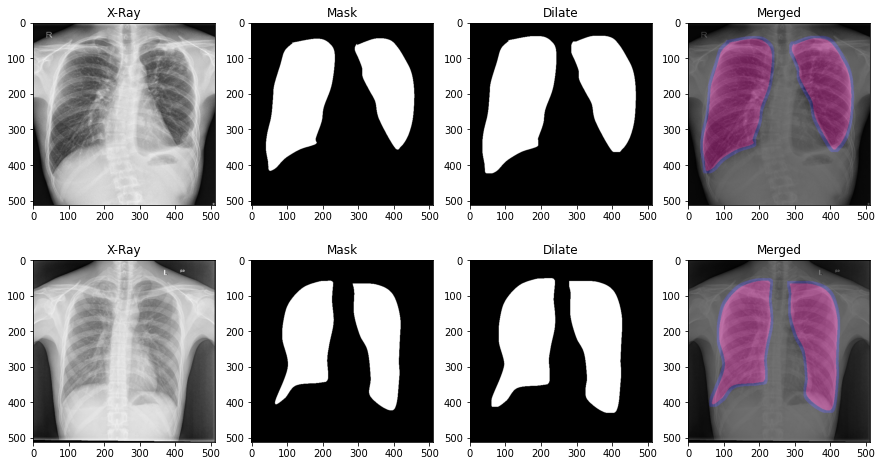

In [9]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(851, 300, 851, 851)

In [10]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir='..',
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [11]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [13]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [16]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))

model = multi_gpu_model(model, gpus=2)

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512, 512, 1)  7759521     lambda_2[0][0]                   
                                                                 lambda_3[0][0]             

42/42 [============================>.] - ETA: 0s - loss: -0.7998 - dice_coef: 0.7998 - binary_accuracy: 0.8834
Epoch 00017: loss improved from -0.75228 to -0.80005, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 75s 2s/step - loss: -0.8003 - dice_coef: 0.8003 - binary_accuracy: 0.8837 - val_loss: -0.7683 - val_dice_coef: 0.7683 - val_binary_accuracy: 0.8930
Epoch 18/120
42/42 [============================>.] - ETA: 0s - loss: -0.8267 - dice_coef: 0.8267 - binary_accuracy: 0.8969
Epoch 00018: loss improved from -0.80005 to -0.82691, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 76s 2s/step - loss: -0.8270 - dice_coef: 0.8271 - binary_accuracy: 0.8971 - val_loss: -0.7993 - val_dice_coef: 0.7993 - val_binary_accuracy: 0.9083
Epoch 19/120
42/42 [============================>.] - ETA: 0s - loss: -0.8429 - dice_coef: 0.8429 - binary_accuracy: 0.9046
Epoch 00019: loss improved from -0.82691 to -0.84300, saving model to unet_lung_seg.h

Epoch 38/120
42/42 [============================>.] - ETA: 0s - loss: -0.8920 - dice_coef: 0.8920 - binary_accuracy: 0.9314
Epoch 00038: loss improved from -0.89123 to -0.89217, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 76s 2s/step - loss: -0.8923 - dice_coef: 0.8923 - binary_accuracy: 0.9315 - val_loss: -0.8827 - val_dice_coef: 0.8827 - val_binary_accuracy: 0.9451
Epoch 39/120
42/42 [============================>.] - ETA: 0s - loss: -0.8903 - dice_coef: 0.8903 - binary_accuracy: 0.9305
Epoch 00039: loss did not improve from -0.89217
43/42 [==============================] - 75s 2s/step - loss: -0.8902 - dice_coef: 0.8902 - binary_accuracy: 0.9304 - val_loss: -0.8684 - val_dice_coef: 0.8684 - val_binary_accuracy: 0.9351
Epoch 40/120
42/42 [============================>.] - ETA: 0s - loss: -0.8950 - dice_coef: 0.8950 - binary_accuracy: 0.9336
Epoch 00040: loss improved from -0.89217 to -0.89510, saving model to unet_lung_seg.hdf5
43/42 [=================

43/42 [==============================] - 76s 2s/step - loss: -0.9218 - dice_coef: 0.9218 - binary_accuracy: 0.9502 - val_loss: -0.9041 - val_dice_coef: 0.9041 - val_binary_accuracy: 0.9531
Epoch 60/120
42/42 [============================>.] - ETA: 0s - loss: -0.9238 - dice_coef: 0.9238 - binary_accuracy: 0.9516
Epoch 00060: loss improved from -0.92159 to -0.92377, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 75s 2s/step - loss: -0.9238 - dice_coef: 0.9238 - binary_accuracy: 0.9516 - val_loss: -0.8989 - val_dice_coef: 0.8989 - val_binary_accuracy: 0.9487
Epoch 61/120
42/42 [============================>.] - ETA: 0s - loss: -0.9181 - dice_coef: 0.9181 - binary_accuracy: 0.9479
Epoch 00061: loss did not improve from -0.92377
43/42 [==============================] - 75s 2s/step - loss: -0.9186 - dice_coef: 0.9186 - binary_accuracy: 0.9480 - val_loss: -0.8995 - val_dice_coef: 0.8995 - val_binary_accuracy: 0.9503
Epoch 62/120
42/42 [============================

42/42 [============================>.] - ETA: 0s - loss: -0.9364 - dice_coef: 0.9364 - binary_accuracy: 0.9595
Epoch 00081: loss improved from -0.93340 to -0.93618, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 76s 2s/step - loss: -0.9361 - dice_coef: 0.9360 - binary_accuracy: 0.9594 - val_loss: -0.9180 - val_dice_coef: 0.9180 - val_binary_accuracy: 0.9589
Epoch 82/120
42/42 [============================>.] - ETA: 0s - loss: -0.9325 - dice_coef: 0.9325 - binary_accuracy: 0.9572
Epoch 00082: loss did not improve from -0.93618
43/42 [==============================] - 75s 2s/step - loss: -0.9322 - dice_coef: 0.9322 - binary_accuracy: 0.9571 - val_loss: -0.9229 - val_dice_coef: 0.9229 - val_binary_accuracy: 0.9618
Epoch 83/120
42/42 [============================>.] - ETA: 0s - loss: -0.9353 - dice_coef: 0.9353 - binary_accuracy: 0.9590
Epoch 00083: loss did not improve from -0.93618
43/42 [==============================] - 76s 2s/step - loss: -0.9357 - dice_co

42/42 [============================>.] - ETA: 0s - loss: -0.9425 - dice_coef: 0.9425 - binary_accuracy: 0.9635
Epoch 00103: loss improved from -0.94098 to -0.94261, saving model to unet_lung_seg.hdf5
43/42 [==============================] - 76s 2s/step - loss: -0.9427 - dice_coef: 0.9427 - binary_accuracy: 0.9636 - val_loss: -0.9438 - val_dice_coef: 0.9438 - val_binary_accuracy: 0.9714
Epoch 104/120
42/42 [============================>.] - ETA: 0s - loss: -0.9429 - dice_coef: 0.9429 - binary_accuracy: 0.9637
Epoch 00104: loss did not improve from -0.94261
43/42 [==============================] - 75s 2s/step - loss: -0.9421 - dice_coef: 0.9421 - binary_accuracy: 0.9635 - val_loss: -0.9277 - val_dice_coef: 0.9277 - val_binary_accuracy: 0.9651
Epoch 105/120
42/42 [============================>.] - ETA: 0s - loss: -0.9423 - dice_coef: 0.9423 - binary_accuracy: 0.9633
Epoch 00105: loss did not improve from -0.94261
43/42 [==============================] - 75s 2s/step - loss: -0.9427 - dice_

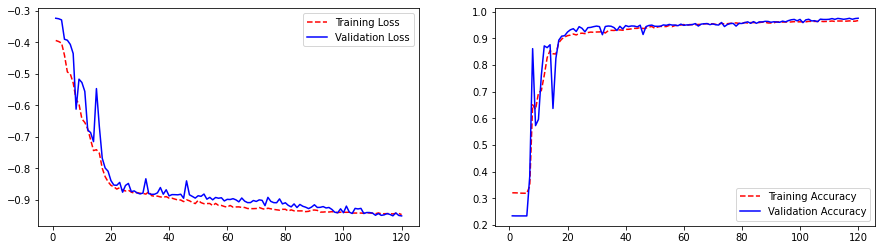

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [18]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

100/100 [==============================] - 2s 21ms/step


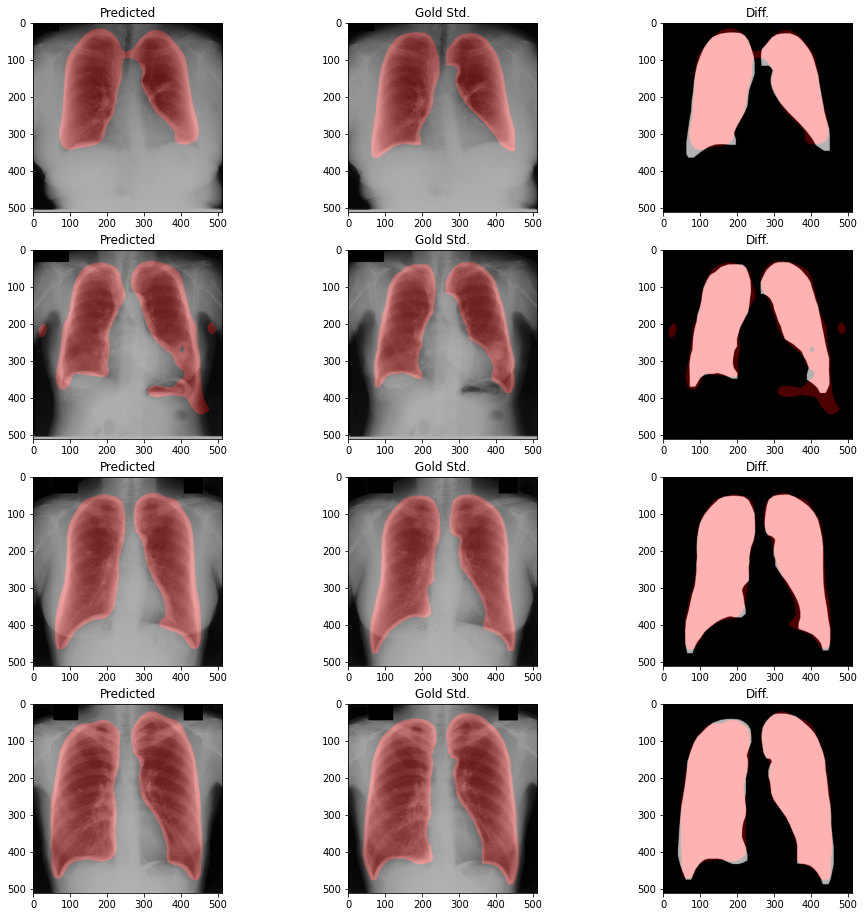

In [20]:
image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN005.png")
predict_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN005_predict.png")
mask_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN005_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN002.png")
predict_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN002_predict.png")
mask_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN002_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN004.png")
predict_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN004_predict.png")
mask_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN004_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN008.png")
predict_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN008_predict.png")
mask_image = cv2.imread("/home/youho/lung_segmentation_practice/practice_1/input/segmentation/test/JPCLN008_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

In [21]:
!tar zcf results.tgz /home/youho/lung_segmentation_practice/practice_1/input/segmentation/test

tar: Removing leading `/' from member names


In [24]:
### saving the model
model.save("montgomery_shenzhen_halfJSRT.h5")

### calling back the model
from keras.models import load_model
# model = load_model(/home/youho/models/montgomery_shenzhen_JSRT_lung_segmentation/"montgomery_shenzhen_halfJSRT")